# Control Networks

In [2]:
!pip install swig
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379368 sha256=cca7cf130874f80c89ac0bf895d62f782a62e521dcfabaa4f230ea01341467e1
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [6]:
import numpy as np
import gymnasium as gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
import collections
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import os
#import torch
#run pip install gym and pip install gym[box2d] in terminal
seed_num = 42


#Define Enviornments with wind of varying levels
# env_no_wind = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
#                enable_wind=False, wind_power=15.0, turbulence_power=1.5)
# env_wind15 = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
#                enable_wind=True, wind_power=15.0, turbulence_power=1.5)
# env_wind5 = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
#                enable_wind=True, wind_power=5.0, turbulence_power=0.5)
# env_wind10 = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
#                enable_wind=True, wind_power=10.0, turbulence_power=1.0)
# env_wind20 = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
#                enable_wind=True, wind_power=20.0, turbulence_power=2.0)
base_env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, render_mode='rgb_array') #, enable_wind=True, wind_power=10, turbulence_power=1.0) # first try no wind
env_pixels = AddRenderObservation(base_env, render_only=False)

# env_wind5.action_space.seed(seed_num)
# env_wind15.action_space.seed(seed_num)
# env_wind20.action_space.seed(seed_num)
# env_wind10.action_space.seed(seed_num)
# env_no_wind.action_space.seed(seed_num)

# envs = [env_no_wind, env_wind5, env_wind10, env_wind15, env_wind20]
envs = [env_pixels]

#######

# Neural Network for Q-function approximation
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

# CNN for image input Q-function approximation
class ConvDQN(nn.Module):
    def __init__(self, input_dim, output_dim, in_channels=3):
        super(ConvDQN, self).__init__()
        self.conv_stream = nn.Sequential(
          nn.Conv2d(in_channels, 32, 5, stride=2, padding=2),
          nn.ReLU(),
          nn.Conv2d(32, 64, 3, stride=2, padding=1),
          nn.ReLU(),
          nn.Conv2d(64, 128, 3, stride=2, padding=1),
          nn.ReLU(),
          nn.Conv2d(128, 128, 3, stride=2, padding=1),
          nn.ReLU()
        )

        self.link = nn.Sequential(
            nn.Linear(128*6*6, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
          )

    def forward(self, x):
      h = self.conv_stream(x)
      h = torch.flatten(h, 1)
      y = self.link(h)

      return self.fc(y)


# Replay buffer to store experiences
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# Deep Q-Learning function with GPU support
def train_dqn(env, episodes, gamma=0.99, lr=1e-3, batch_size=64, buffer_capacity=100000, epsilon_start=1.0, epsilon_min=0.1, epsilon_decay=0.995):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n
    dqn = DQN(input_dim, output_dim).to(device)
    optimizer = optim.Adam(dqn.parameters(), lr=lr)
    criterion = nn.MSELoss()
    buffer = ReplayBuffer(buffer_capacity)
    epsilon = epsilon_start

    rewards = []  # Initialize as a Python list
    for episode in range(episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        total_reward = 0

        for t in range(1000):  # max steps per episode
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    action = torch.argmax(dqn(state)).item()

            # Take action
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
            buffer.add(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward

            # Train the DQN
            if len(buffer) >= batch_size:
                batch = buffer.sample(batch_size)
                states, actions, rewards_batch, next_states, dones = zip(*batch)

                states = torch.cat(states).float().to(device)
                actions = torch.tensor(actions, dtype=torch.long, device=device).unsqueeze(1)
                rewards_batch = torch.tensor(rewards_batch, dtype=torch.float32, device=device).unsqueeze(1)
                next_states = torch.cat(next_states).float().to(device)
                dones = torch.tensor(dones, dtype=torch.float32, device=device).unsqueeze(1)

                q_values = dqn(states).gather(1, actions)
                with torch.no_grad():
                    max_next_q_values = dqn(next_states).max(1, keepdim=True)[0]
                    target_q_values = rewards_batch + gamma * max_next_q_values * (1 - dones)

                loss = criterion(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                break

        rewards.append(total_reward)  # Append total_reward to Python list
        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        print(f"Episode {episode+1}, Reward: {total_reward}, Epsilon: {epsilon}")

    return rewards, dqn


# handle dd
def train_ddqn(env, episodes, gamma=0.99, lr=1e-3, batch_size=64, buffer_capacity=100000,
               epsilon_start=1.0, epsilon_min=0.1, epsilon_decay=0.995, target_update_freq=10):
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    # Initialize both the Q-network and the Target network
    q_network = DQN(input_dim, output_dim).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    target_network = DQN(input_dim, output_dim).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    target_network.load_state_dict(q_network.state_dict())  # Initialize target with Q-network weights
    target_network.eval()  # Target network in evaluation mode

    optimizer = optim.Adam(q_network.parameters(), lr=lr)
    criterion = nn.MSELoss()
    buffer = ReplayBuffer(buffer_capacity)
    epsilon = epsilon_start

    rewards = []
    for episode in range(episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        total_reward = 0

        for t in range(1000):  # max steps per episode
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    action = torch.argmax(q_network(state)).item()

            # Take action
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
            buffer.add(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward

            # Train the Q-network
            if len(buffer) >= batch_size:
                batch = buffer.sample(batch_size)
                states, actions, rewards_batch, next_states, dones = zip(*batch)

                states = torch.cat(states).float()
                actions = torch.tensor(actions).unsqueeze(1)
                rewards_batch = torch.tensor(rewards_batch, dtype=torch.float32).unsqueeze(1)
                next_states = torch.cat(next_states).float()
                dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

                # Q-values for chosen actions
                q_values = q_network(states).gather(1, actions)


                with torch.no_grad():
                    # ddqn adjustments
                    next_actions = torch.argmax(q_network(next_states), dim=1, keepdim=True)
                    next_q_values = target_network(next_states).gather(1, next_actions)
                    target_q_values = rewards_batch + gamma * next_q_values * (1 - dones)

                loss = criterion(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                break

        rewards.append(total_reward)
        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        print(f"Episode {episode+1}, Reward: {total_reward}, Epsilon: {epsilon}")

        # Update target network periodically
        if episode % target_update_freq == 0:
            target_network.load_state_dict(q_network.state_dict())

    return rewards, q_network

######################

# Dueling dqn architechure
class DuelingDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DuelingDQN, self).__init__()
        self.feature_layer = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU()
        )
        # Value stream
        self.value_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Single output for V(s)
        )
        # Advantage stream
        self.advantage_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)  # Outputs for A(s, a)
        )

    def forward(self, x):
        features = self.feature_layer(x)
        value = self.value_stream(features)
        advantage = self.advantage_stream(features)
        # Combine value and advantage streams
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_values

# literally vanilla but with dueling architecture
def train_dueling_dqn(env, episodes, gamma=0.99, lr=1e-3, batch_size=64, buffer_capacity=100000, epsilon_start=1.0, epsilon_min=0.1, epsilon_decay=0.995):
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n
    dqn = DuelingDQN(input_dim, output_dim).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    optimizer = optim.Adam(dqn.parameters(), lr=lr)
    criterion = nn.MSELoss()
    buffer = ReplayBuffer(buffer_capacity)
    epsilon = epsilon_start

    rewards = []  # Initialize as a Python list
    for episode in range(episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        total_reward = 0

        for t in range(1000):  # max steps per episode
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    action = torch.argmax(dqn(state)).item()

            # Take action
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
            buffer.add(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward

            # Train the DQN
            if len(buffer) >= batch_size:
                batch = buffer.sample(batch_size)
                states, actions, rewards_batch, next_states, dones = zip(*batch)

                states = torch.cat(states).float()
                actions = torch.tensor(actions).unsqueeze(1)
                rewards_batch = torch.tensor(rewards_batch, dtype=torch.float32).unsqueeze(1)
                next_states = torch.cat(next_states).float()
                dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

                q_values = dqn(states).gather(1, actions)
                with torch.no_grad():
                    max_next_q_values = dqn(next_states).max(1, keepdim=True)[0]
                    target_q_values = rewards_batch + gamma * max_next_q_values * (1 - dones)

                loss = criterion(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                break

        rewards.append(total_reward)  # Append total_reward to Python list
        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        print(f"Episode {episode+1}, Reward: {total_reward}, Epsilon: {epsilon}")

    return rewards, dqn

In [ ]:
# random baseline
env = gym.make("LunarLander-v3", render_mode='rgb_array')
env.action_space.seed(seed_num)
def ll_random(env, num_iter, max_steps=1000, render=False):
    #List of total rewards over iterations
    rewards = []

    for i in range(num_iter):
        #Reset env
        obs, info = env.reset()
        iter_reward = 0
        num_steps = 0

        #Take steps until termination condition
        while num_steps < max_steps:
            #Take a step
            observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
            #Add R(s,a) to cumulative reward over an iteration
            iter_reward += reward
            #if render: env.render()
            if terminated or truncated:
                rewards.append(iter_reward)
                break

    return np.array(rewards)

random_trials_rewards = ll_random(env, num_iter=1000)
random_trials_mean = np.mean(random_trials_rewards)

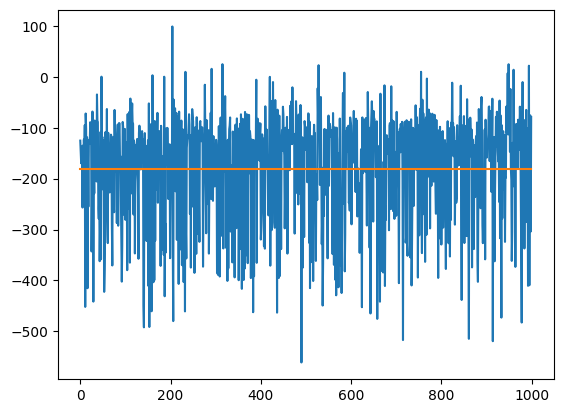

In [ ]:
plt.plot(random_trials_rewards)
plt.plot([random_trials_mean] * len(random_trials_rewards))
plt.show()

In [13]:
# training script
NUM_EPISODES = 2000

if __name__ == "__main__":
    # Define paths for results and weights
    results_folder = "experiments"
    weights_folder = "weights"
    os.makedirs(results_folder, exist_ok=True)
    os.makedirs(weights_folder, exist_ok=True)

    # Map algorithm names to training functions
    algorithms = {
        #"DQN": train_dqn,
        #"DDQN": train_ddqn,
        #"DuelingDQN": train_dueling_dqn,
        #"DQN_pix": train_dqn_with_pixels,
        "ConvDDQN": train_conv_ddqn
    }

    # Run experiments
    for env_idx, env in enumerate(envs):
        env_name = f"env_wind_{env_idx}"
        print(f"Running experiments for {env_name}...")

        for algo_name, algo_function in algorithms.items():
            print(f"Training {algo_name} on {env_name}...")
            rewards, model = algo_function(env, episodes=NUM_EPISODES)

            # Save rewards
            rewards_path = os.path.join(results_folder, f"{env_name}_{algo_name}_rewards.txt")
            with open(rewards_path, "w") as f:
                for reward in rewards:
                    f.write(f"{reward}\n")

            # Save model weights
            weights_path = os.path.join(weights_folder, f"{env_name}_{algo_name}_weights.pt")
            torch.save(model.state_dict(), weights_path)

            print(f"{algo_name} on {env_name} completed. Rewards and weights saved.")

    print("All experiments completed.")

Running experiments for env_wind_0...
Training ConvDDQN on env_wind_0...
cuda
Episode 1: return=-103.5  epsilon=0.999
Episode 2: return=-156.1  epsilon=0.998
Episode 3: return=-73.9  epsilon=0.997
Episode 4: return=-302.7  epsilon=0.996
Episode 5: return=-168.2  epsilon=0.995
Episode 6: return=-263.3  epsilon=0.994
Episode 7: return=-228.7  epsilon=0.993
Episode 8: return=-30.4  epsilon=0.992
Episode 9: return=-291.8  epsilon=0.991
Episode 10: return=-99.3  epsilon=0.990
Episode 11: return=-54.6  epsilon=0.989
Episode 12: return=-291.9  epsilon=0.988
Episode 13: return=-219.3  epsilon=0.987
Episode 14: return=-133.7  epsilon=0.986
Episode 15: return=-251.4  epsilon=0.985
Episode 16: return=-106.9  epsilon=0.984
Episode 17: return=-154.1  epsilon=0.983
Episode 18: return=-246.3  epsilon=0.982
Episode 19: return=-115.1  epsilon=0.981
Episode 20: return=-413.9  epsilon=0.980
Episode 21: return=-98.7  epsilon=0.979
Episode 22: return=-348.6  epsilon=0.978
Episode 23: return=-113.1  epsilon

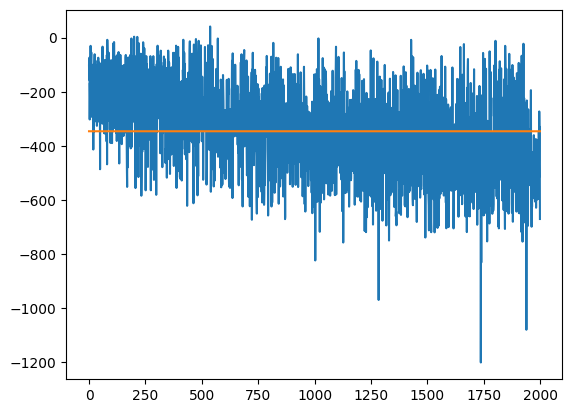

In [14]:
convdqn_rewards = np.loadtxt("experiments/env_wind_0_ConvDDQN_rewards.txt")
plt.plot(convdqn_rewards)
plt.plot([np.mean(convdqn_rewards)] * len(convdqn_rewards))
plt.show()

Still very poor!

# Control Visualizations

In [ ]:
# visualize performances
def select_action(state, model, epsilon=0.0):
    if random.random() < epsilon:  # Explore
        return env.action_space.sample()
    else:  # Exploit
        with torch.no_grad():
            q_values = model(state)
            action = torch.argmax(q_values).item()
        return action

def simulate(model):
    env = gym.make("LunarLander-v3", render_mode='rgb_array', enable_wind=True, wind_power=10, turbulence_power=1.0)
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

    img = plt.imshow(env.render())
    rewards = 0
    for _ in range(1000):
        img.set_data(env.render()) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        action = select_action(state, model, epsilon=0.0)  # Greedy action
        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
        state = next_state
        rewards += reward

        if terminated or truncated:
            state, _ = env.reset()
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            print(f'rewards = {rewards}')
            rewards = 0

    env.close()

def load_model(model_class, input_dim, output_dim, weights_path):
    """
    Reinitializes a model and loads weights from a .pth file.

    Parameters:
        model_class: The class of the model (e.g., DQN, DuelingDQN).
        input_dim: The input dimension for the model.
        output_dim: The output dimension for the model.
        weights_path: Path to the saved weights (.pth file).

    Returns:
        A model instance with loaded weights.
    """
    # Initialize the model
    model = model_class(input_dim, output_dim)

    # Load the saved weights
    model.load_state_dict(torch.load(weights_path))

    # Set the model to evaluation mode
    model.eval()

    return model

# Example: Reloading a DQN model
input_dim = 8  # Adjust based on your environment's observation space
output_dim = 4  # Adjust based on your environment's action space
weights_path = "weights/env_wind_0_DQN_weights.pth"  # Path to the saved weights

# Reinitialize the model
dqn_model = load_model(DQN, input_dim, output_dim, weights_path)

In [ ]:
simulate(dqn_model)

In [ ]:
simulate(ddqn_model)

In [ ]:
simulate(dueling_dqn_model)

# Computer Vision State Extraction

## Basic Image Extraction

In [5]:
from gymnasium.wrappers import AddRenderObservation

# basic setup
base_env = gym.make("LunarLander-v3", render_mode='rgb_array')
base_env.action_space.seed(seed_num)

# pixels without rendering each time
env = AddRenderObservation(base_env, render_only=False) # may need to call exact 'state' key in control with this
obs, _ = env.reset()
pixels = obs["pixels"] # H x W x 3 uint8 array of current RGB image
print(pixels.shape)

(400, 600, 3)


## Dataset Assembly

In [5]:
import cv2 as cv
from tqdm import trange

In [9]:
# dataset func
def assemble_dataset(n_steps, img_size, seed=seed_num, decision_model=None):
  base_env = gym.make("LunarLander-v3", render_mode='rgb_array')
  env = AddRenderObservation(base_env, render_only=False)
  obs, _ = env.reset(seed=seed)

  # sizing if we downscale images
  if img_size is None:
    img_size = (pixels.shape[0], pixels.shape[1])

  X_img, Y_state = [], []
  steps = 0
  for step in trange(n_steps):
    frame, state_vector = obs["pixels"], obs["state"]

    # resize for speed to start
    frame_resized = cv.resize(frame, img_size, interpolation=cv.INTER_AREA)

    X_img.append(frame_resized.astype(np.uint8))
    Y_state.append(np.asarray(state_vector, dtype=np.float32))
    if decision_model is not None: # using pretrained controller allows for more rewarding states (leg down) to be seen
      prep_state = torch.tensor(state_vector, dtype=torch.float32).unsqueeze(0)
      action = select_action(prep_state, decision_model, epsilon=0.0)
    else:
      action = env.action_space.sample()
    obs, _, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    if done:
      obs, _ = env.reset() # seeded or no??

  env.close()

  X = np.stack(X_img, axis=0) # [N, H, W, 3] or N RGB images
  Y = np.stack(Y_state, axis=0) # [N, 8] or N 8D state vectors

  # save dataset
  save_file = "lander_pixels_states_cv2"
  if decision_model is not None:
    save_file += "_decision"
  np.savez_compressed("" + save_file + ".npz", X=X, Y=Y)
  print(f"Saved {save_file}.npz", X.shape, Y.shape)
  return X, Y

In [18]:
# compile dataset
assemble_dataset(n_steps=60000, img_size=(96, 96), decision_model=dqn_model)

100%|██████████| 60000/60000 [04:46<00:00, 209.12it/s]


Saved lander_pixels_states_cv2_decision.npz (60000, 96, 96, 3) (60000, 8)


(array([[[[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],
 
         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],
 
         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],
 
         ...,
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
   

## Naive Single Network

### CNN Training

In [6]:
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import time

In [11]:
# Dataloader setup
class LanderDataset(Dataset):
  def __init__(self, X, Y, mean=None, std=None):
    self.X = X
    self.Y = Y

    # for normalization
    self.mean = mean if mean is not None else Y.mean(axis=0, keepdims=True)
    self.std  = std  if std  is not None else Y.std(axis=0, keepdims=True) + 1e-6

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
        img = self.X[i].astype(np.float32) / 255.0
        img = np.transpose(img, (2,0,1))
        y = (self.Y[i] - self.mean[0]) / self.std[0]
        return torch.from_numpy(img), torch.from_numpy(y)

# CNN Utility
class CNN(nn.Module):
  def __init__(self, out_dim, in_channels=3):
    super().__init__()
    self.conv_stream = nn.Sequential(
        nn.Conv2d(in_channels, 32, 5, stride=2, padding=2),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 128, 3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, 3, stride=2, padding=1),
        nn.ReLU()
    )

    self.head = nn.Sequential(
        nn.Linear(128*6*6, 256),
        nn.ReLU(),
        nn.Linear(256, out_dim)
    )

  def forward(self, x):
    h = self.conv_stream(x)
    h = torch.flatten(h, 1)
    y = self.head(h)

    return y


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [19]:
# prep data
dataset_file = "lander_pixels_states_cv2_decision.npz"
data = np.load(dataset_file)
X, Y = data["X"], data["Y"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

# only normalize
mean, std = Y_train.mean(axis=0, keepdims=True), Y_train.std(axis=0, keepdims=True) + 1e-6

train_dataset = LanderDataset(X_train, Y_train, mean=mean, std=std)
test_dataset = LanderDataset(X_test, Y_test, mean=mean, std=std)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2, pin_memory=False, persistent_workers=True)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=2, pin_memory=False, persistent_workers=True)

cuda


In [20]:
# train function
def train(model, epochs, loss_fn, optimizer, device):
  for epoch in trange(epochs):
    model.train()
    for x,y in train_dataloader: # could generalize with dl
        x,y = x.to(device), y.to(device)
        yhat = model(x)
        loss = loss_fn(yhat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"epoch {epoch:02d} | train {evaluate(train_dataloader):.4f} | val {evaluate(test_dataloader):.4f}")

In [21]:
# eval function
def evaluate(dl):
    model.eval()
    sum_error, n = 0.0, 0
    with torch.no_grad():
        for x,y in dl:
            x,y = x.to(device), y.to(device)
            yhat = model(x)
            sum_error += ((yhat - y)**2).sum().item()
            n  += y.numel()
    return (sum_error/n)**0.5

In [22]:
train_dataset[0][0].shape

torch.Size([3, 96, 96])

In [26]:
# smooth lp to analogy l-inf norm
def loss_function(yhat, y, p=8):
  e = (yhat - y).abs() ** p
  return ((e.mean(dim=1))**(1/p)).sum()

In [23]:
# prep training
model = CNN(out_dim=8).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss() #loss_function, normalized features so try just this/huber for now

# actually train model
train(model, epochs=50, loss_fn=criterion, optimizer=optimizer, device=device)

  2%|▏         | 1/50 [00:22<18:07, 22.19s/it]

epoch 00 | train 0.4925 | val 0.4892


  4%|▍         | 2/50 [00:43<17:07, 21.41s/it]

epoch 01 | train 0.4306 | val 0.4321


  6%|▌         | 3/50 [01:02<16:13, 20.71s/it]

epoch 02 | train 0.3765 | val 0.3802


  8%|▊         | 4/50 [01:23<15:45, 20.55s/it]

epoch 03 | train 0.3489 | val 0.3537


 10%|█         | 5/50 [01:43<15:26, 20.58s/it]

epoch 04 | train 0.3316 | val 0.3419


 12%|█▏        | 6/50 [02:04<15:02, 20.50s/it]

epoch 05 | train 0.3178 | val 0.3284


 14%|█▍        | 7/50 [02:25<14:46, 20.62s/it]

epoch 06 | train 0.2998 | val 0.3069


 16%|█▌        | 8/50 [02:44<14:12, 20.29s/it]

epoch 07 | train 0.2932 | val 0.2995


 18%|█▊        | 9/50 [03:05<13:57, 20.42s/it]

epoch 08 | train 0.2765 | val 0.2832


 20%|██        | 10/50 [03:25<13:27, 20.18s/it]

epoch 09 | train 0.2835 | val 0.2872


 22%|██▏       | 11/50 [03:45<13:12, 20.33s/it]

epoch 10 | train 0.2678 | val 0.2785


 24%|██▍       | 12/50 [04:06<12:59, 20.52s/it]

epoch 11 | train 0.2691 | val 0.2760


 26%|██▌       | 13/50 [04:26<12:32, 20.33s/it]

epoch 12 | train 0.2682 | val 0.2755


 28%|██▊       | 14/50 [04:47<12:16, 20.45s/it]

epoch 13 | train 0.2604 | val 0.2725


 30%|███       | 15/50 [05:06<11:47, 20.22s/it]

epoch 14 | train 0.2553 | val 0.2646


 32%|███▏      | 16/50 [05:27<11:30, 20.30s/it]

epoch 15 | train 0.2520 | val 0.2667


 34%|███▍      | 17/50 [05:47<11:03, 20.10s/it]

epoch 16 | train 0.2495 | val 0.2577


 36%|███▌      | 18/50 [06:07<10:50, 20.32s/it]

epoch 17 | train 0.2448 | val 0.2564


 38%|███▊      | 19/50 [06:28<10:30, 20.33s/it]

epoch 18 | train 0.2494 | val 0.2617


 40%|████      | 20/50 [06:48<10:07, 20.25s/it]

epoch 19 | train 0.2432 | val 0.2561


 42%|████▏     | 21/50 [07:09<09:51, 20.39s/it]

epoch 20 | train 0.2398 | val 0.2539


 44%|████▍     | 22/50 [07:28<09:24, 20.16s/it]

epoch 21 | train 0.2402 | val 0.2543


 46%|████▌     | 23/50 [07:49<09:06, 20.22s/it]

epoch 22 | train 0.2393 | val 0.2502


 48%|████▊     | 24/50 [08:09<08:44, 20.16s/it]

epoch 23 | train 0.2368 | val 0.2482


 50%|█████     | 25/50 [08:29<08:26, 20.25s/it]

epoch 24 | train 0.2349 | val 0.2495


 52%|█████▏    | 26/50 [08:49<08:02, 20.09s/it]

epoch 25 | train 0.2366 | val 0.2546


 54%|█████▍    | 27/50 [09:09<07:46, 20.27s/it]

epoch 26 | train 0.2382 | val 0.2525


 56%|█████▌    | 28/50 [09:30<07:29, 20.43s/it]

epoch 27 | train 0.2390 | val 0.2521


 58%|█████▊    | 29/50 [09:50<07:03, 20.19s/it]

epoch 28 | train 0.2403 | val 0.2528


 60%|██████    | 30/50 [10:11<06:47, 20.37s/it]

epoch 29 | train 0.2306 | val 0.2478


 62%|██████▏   | 31/50 [10:30<06:23, 20.19s/it]

epoch 30 | train 0.2339 | val 0.2509


 64%|██████▍   | 32/50 [10:51<06:05, 20.29s/it]

epoch 31 | train 0.2297 | val 0.2439


 66%|██████▌   | 33/50 [11:10<05:41, 20.07s/it]

epoch 32 | train 0.2432 | val 0.2579


 68%|██████▊   | 34/50 [11:31<05:23, 20.22s/it]

epoch 33 | train 0.2249 | val 0.2405


 70%|███████   | 35/50 [11:51<05:00, 20.03s/it]

epoch 34 | train 0.2278 | val 0.2433


 72%|███████▏  | 36/50 [12:11<04:43, 20.26s/it]

epoch 35 | train 0.2235 | val 0.2396


 74%|███████▍  | 37/50 [12:32<04:24, 20.36s/it]

epoch 36 | train 0.2181 | val 0.2390


 76%|███████▌  | 38/50 [12:52<04:02, 20.17s/it]

epoch 37 | train 0.2228 | val 0.2417


 78%|███████▊  | 39/50 [13:13<03:44, 20.45s/it]

epoch 38 | train 0.2209 | val 0.2387


 80%|████████  | 40/50 [13:33<03:22, 20.22s/it]

epoch 39 | train 0.2187 | val 0.2357


 82%|████████▏ | 41/50 [13:53<03:03, 20.37s/it]

epoch 40 | train 0.2259 | val 0.2439


 84%|████████▍ | 42/50 [14:14<02:43, 20.38s/it]

epoch 41 | train 0.2177 | val 0.2366


 86%|████████▌ | 43/50 [14:34<02:22, 20.37s/it]

epoch 42 | train 0.2160 | val 0.2401


 88%|████████▊ | 44/50 [14:54<02:02, 20.39s/it]

epoch 43 | train 0.2111 | val 0.2340


 90%|█████████ | 45/50 [15:15<01:41, 20.36s/it]

epoch 44 | train 0.2155 | val 0.2343


 92%|█████████▏| 46/50 [15:35<01:21, 20.47s/it]

epoch 45 | train 0.2200 | val 0.2361


 94%|█████████▍| 47/50 [15:55<01:00, 20.24s/it]

epoch 46 | train 0.2178 | val 0.2388


 96%|█████████▌| 48/50 [16:16<00:40, 20.48s/it]

epoch 47 | train 0.2150 | val 0.2331


 98%|█████████▊| 49/50 [16:36<00:20, 20.21s/it]

epoch 48 | train 0.2133 | val 0.2336


100%|██████████| 50/50 [16:57<00:00, 20.34s/it]

epoch 49 | train 0.2091 | val 0.2294


In [24]:
# save model
torch.save({"state_dict": model.state_dict(), "y_mean": mean, "y_std": std}, "lander_state_from_pixels_cv2_decision.pt")

### Model Inference

In [51]:
# predict state from frame
checkpoint="lander_state_from_pixels_cv2_decision.pt"
ckpt = torch.load(checkpoint, map_location=device, weights_only=False)
y_mean, y_std = ckpt["y_mean"], ckpt["y_std"]
cv_model = CNN(out_dim=8).to(device)
cv_model.load_state_dict(ckpt["state_dict"])
cv_model.eval()
def predict_state_from_frame(frame, eval_model, img_size=(96,96), device=None):
    img = cv.resize(frame, img_size, interpolation=cv.INTER_AREA)
    arr = (img.astype(np.float32) / 255.0).transpose(2,0,1)[None]
    x = torch.from_numpy(arr).to(device)


    with torch.no_grad():
      # call network and dimensionalize
      yhat_z = eval_model(x).cpu().numpy()[0]
      yhat = yhat_z * y_std[0] + y_mean[0]

      return yhat

def prep_img_state(frame, img_size=(96,96), device=None):
    img = cv.resize(frame, img_size, interpolation=cv.INTER_AREA)
    arr = (img.astype(np.float32) / 255.0).transpose(2,0,1)[None]
    x = torch.from_numpy(arr).to(device)

    return x

### Integrated Simulation

In [37]:
# visualize performances
def select_action(state, model, epsilon=0.0):
    if random.random() < epsilon:  # Explore
        return env.action_space.sample()
    else:  # Exploit
        with torch.no_grad():
            q_values = model(state)
            action = torch.argmax(q_values).item()
        return action

# plain sim
def simulate(model):
    env = gym.make("LunarLander-v3", render_mode='rgb_array', enable_wind=True, wind_power=10, turbulence_power=1.0)
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

    img = plt.imshow(env.render())
    rewards = 0
    for _ in range(1000):
        img.set_data(env.render()) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        action = select_action(state, model, epsilon=0.0)  # Greedy action
        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
        state = next_state
        rewards += reward

        if terminated or truncated:
            state, _ = env.reset()
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            print(f'rewards = {rewards}')
            rewards = 0

    env.close()

def load_model(model_class, input_dim, output_dim, weights_path):
    """
    Reinitializes a model and loads weights from a .pth file.

    Parameters:
        model_class: The class of the model (e.g., DQN, DuelingDQN).
        input_dim: The input dimension for the model.
        output_dim: The output dimension for the model.
        weights_path: Path to the saved weights (.pth file).

    Returns:
        A model instance with loaded weights.
    """
    #if device is None:
        #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize the model
    model = model_class(input_dim, output_dim).to("cpu")

    # Load the saved weights
    model_state = torch.load(weights_path, map_location="cpu", weights_only=False)
    model.load_state_dict(model_state, strict=True)

    # Set the model to evaluation mode
    model.eval()

    return model

# integrated sim
def simulate_with_cv(model, eval_model):
    #base_env = gym.make("LunarLander-v3", render_mode='rgb_array') #, enable_wind=True, wind_power=10, turbulence_power=1.0) # first try no wind
    base_env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, render_mode='rgb_array')
    env = AddRenderObservation(base_env, render_only=False)
    sim_datastore = sim_data()
    sim_datastore.clear()

    obs, _ = env.reset()

    frame = obs["pixels"]
    state = predict_state_from_frame(frame, eval_model, device=device)

    # store
    sim_datastore.true_state_list.append(np.array(obs["state"]))
    sim_datastore.estimated_state_list.append(np.array(state))
    #state = sim_datastore.correct_state(state)

    # prep for model
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

    img = plt.imshow(env.render())
    rewards = 0
    for _ in range(1000):
        img.set_data(env.render()) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        action = select_action(state, model, epsilon=0.0)  # Greedy action
        sim_datastore.actions.append(action)

        # step
        next_state, reward, terminated, truncated, _ = env.step(action)

        # store
        frame = next_state["pixels"]
        state = predict_state_from_frame(frame, eval_model, device=device)
        sim_datastore.true_state_list.append(np.array(next_state["state"]))
        sim_datastore.estimated_state_list.append(np.array(state))
        #state = sim_datastore.correct_state(state)

        # prep for model
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        rewards += reward

        if terminated or truncated:
            obs, _ = env.reset()
            frame = obs["pixels"]
            state = predict_state_from_frame(frame, eval_model, device=device)
            sim_datastore.true_state_list.append(np.array(next_state["state"]))
            sim_datastore.estimated_state_list.append(np.array(state))
            #state = sim_datastore.correct_state(state)
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            print(f'rewards = {rewards}')
            rewards = 0
            return sim_datastore

    env.close()

In [44]:
# Integrate Vision with Deep Q-Learning function
def train_dqn_with_pixels(env, episodes, gamma=0.99, lr=1e-3, batch_size=64, buffer_capacity=100000, epsilon_start=1.0, epsilon_min=0.1, epsilon_decay=0.995):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    obs, _ = env.reset()
    input_dim = 8 #env.observation_space.shape[0]
    output_dim = 4
    dqn = DQN(input_dim, output_dim).to(device)
    optimizer = optim.Adam(dqn.parameters(), lr=lr)
    criterion = nn.MSELoss()
    buffer = ReplayBuffer(buffer_capacity)
    epsilon = epsilon_start

    rewards = []
    for episode in range(episodes):
        obs, _ = env.reset()
        frame = obs["pixels"]
        state = predict_state_from_frame(frame, cv_model, device=device)
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        total_reward = 0

        for t in range(1000):  # max steps per episode
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    action = torch.argmax(dqn(state)).item()

            # Take action
            next_state, reward, terminated, truncated, _ = env.step(action)

            # Use vision
            frame = next_state["pixels"]
            next_state = predict_state_from_frame(frame, cv_model, device=device)

            done = terminated or truncated
            next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
            buffer.add(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward

            # Train the DQN
            if len(buffer) >= batch_size:
                batch = buffer.sample(batch_size)
                states, actions, rewards_batch, next_states, dones = zip(*batch)

                states = torch.cat(states).float().to(device)
                actions = torch.tensor(actions, dtype=torch.long, device=device).unsqueeze(1)
                rewards_batch = torch.tensor(rewards_batch, dtype=torch.float32, device=device).unsqueeze(1)
                next_states = torch.cat(next_states).float().to(device)
                dones = torch.tensor(dones, dtype=torch.float32, device=device).unsqueeze(1)

                q_values = dqn(states).gather(1, actions)
                with torch.no_grad():
                    max_next_q_values = dqn(next_states).max(1, keepdim=True)[0]
                    target_q_values = rewards_batch + gamma * max_next_q_values * (1 - dones)

                loss = criterion(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                break

        rewards.append(total_reward)  # Append total_reward
        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        print(f"Episode {episode+1}, Reward: {total_reward}, Epsilon: {epsilon}")

    return rewards, dqn


In [57]:
# E2E Conv Deep Q-Learning function
def train_conv_dqn(env, episodes, gamma=0.99, lr=1e-3, batch_size=128, buffer_capacity=50000, epsilon_start=1.0, epsilon_min=0.1, epsilon_decay=0.9985):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    obs, _ = env.reset()
    input_dim = 8 #env.observation_space.shape[0]
    output_dim = 4
    dqn = ConvDQN(input_dim, output_dim).to(device)
    optimizer = optim.Adam(dqn.parameters(), lr=lr)
    criterion = nn.MSELoss()
    buffer = ReplayBuffer(buffer_capacity)
    epsilon = epsilon_start

    rewards = []  # Initialize as a Python list
    for episode in range(episodes):
        obs, _ = env.reset()
        frame = obs["pixels"]
        state = prep_img_state(frame, device=device)
        total_reward = 0

        for t in range(1000):  # max steps per episode
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    action = torch.argmax(dqn(state)).item()

            # Take action
            next_state, reward, terminated, truncated, _ = env.step(action)

            # use vision
            frame = next_state["pixels"]
            next_state = prep_img_state(frame, device=device)

            done = terminated or truncated
            buffer.add(state, action, reward, next_state, done) # might have to detach when adding to buffer

            state = next_state
            total_reward += reward

            # Train the DQN
            if len(buffer) >= batch_size:
                batch = buffer.sample(batch_size)
                states, actions, rewards_batch, next_states, dones = zip(*batch)

                states = torch.cat(states).float().to(device)
                actions = torch.tensor(actions, dtype=torch.long, device=device).unsqueeze(1)
                rewards_batch = torch.tensor(rewards_batch, dtype=torch.float32, device=device).unsqueeze(1)
                next_states = torch.cat(next_states).float().to(device)
                dones = torch.tensor(dones, dtype=torch.float32, device=device).unsqueeze(1)

                q_values = dqn(states).gather(1, actions)
                with torch.no_grad():
                    max_next_q_values = dqn(next_states).max(1, keepdim=True)[0]
                    target_q_values = rewards_batch + gamma * max_next_q_values * (1 - dones)

                loss = criterion(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                break

        rewards.append(total_reward)  # Append total_reward to Python list
        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        print(f"Episode {episode+1}, Reward: {total_reward}, Epsilon: {epsilon}")

    return rewards, dqn


In [61]:
input_dim = 8
output_dim = 4
weights_path = "weights/env_wind_3_ConvDQN_weights.pt"

# Reinitialize the model
dqn_model = load_model(ConvDQN, input_dim, output_dim, weights_path)

In [62]:
type(dqn_model)

__main__.ConvDQN

rewards = 142.6135588117622


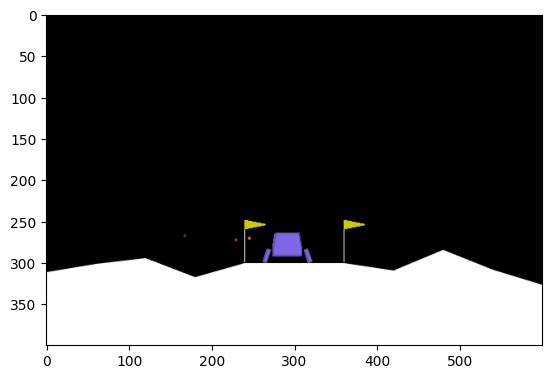

In [17]:
simulate(dqn_model)

rewards = -263.9938223610198


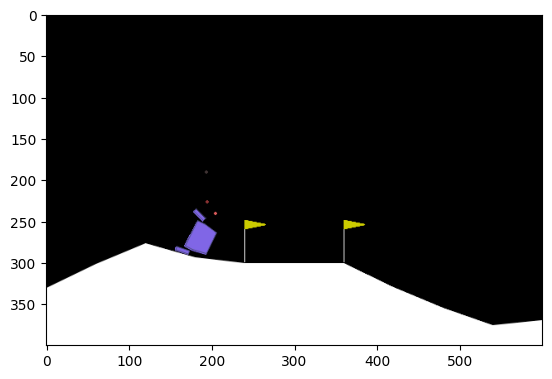

In [48]:
collected_data = simulate_with_cv(dqn_model, cv_model)

/tmp/ipython-input-4038657064.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


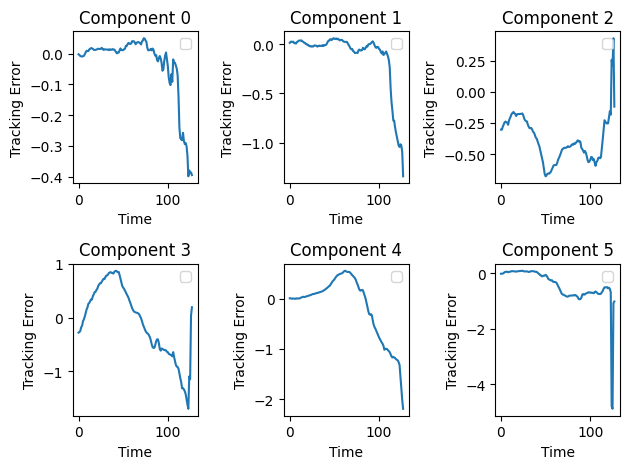

In [49]:
collected_data.plot_tracking_error()

In [76]:
print(collected_data.true_state_list[10])
print(collected_data.estimated_state_list[10])

[-0.00969706  1.3625628  -0.08918383 -0.32863793  0.0110105   0.01995363
  0.          0.        ]
[-0.01964076  1.344057   -0.12813526 -0.4417889  -0.0181127  -0.01824084
 -0.00178489  0.00395923]


### Error Analysis

Conclusions:
- The pipeline is performing very poorly, though clearly can still react to the environment.

Improvements:
- Using a DQN trained under uncertainty: With 10 wind, this does improve performance but still not to an acceptable degree. With 20 wind controller performance is terrible. The system seems to strugle with angular velocity estimation.
- Retraining CNN with lp loss is better, but still seems to struggle with linear and angular velocity. This suggests I should take this load off the CNN and calculate v, w with FDM.
- Corrective velocity and rate calculations don't give any real noticable improvements. Tracking error does well for a bit and then runs away -- this screams KF state estimation. Before KF, try scaling up CNN with more detailed dataset (generated with controller over random actions to give more states with leg down for example).
- Scaling and dataset improvement still yields suboptimal performance.
- After retraining DQN controller with CNN state estimator, performance is still poor; it might even be reward hacking to fastest descent to minimize penalty. While more sophisticated computer vision methods (ex. using bounding box for position from pretrained model) might help, the current CNN scores acceptably. Thus, it seems an E2E network going image-->action is necessary
- Suprisingly, E2E network also performs quite poorly.

Next Steps:
- To maintain decoupled pipeline:
  - Add in state estimation/nav with KF (prob UKF given measurement function)
  - Try distributed networks

In [26]:
class sim_data():
  def __init__(self):
    self.true_state_list = []
    self.estimated_state_list = []
    self.actions = []

  def _get_velocity(self): # could kf this
    if len(self.estimated_state_list) <= 1:
      return self.estimated_state_list[0][:2]
    else:
      return self.estimated_state_list[-1][:2] - self.estimated_state_list[-2][:2] # single difference

  def _get_rate(self):
    if len(self.estimated_state_list) <= 1:
      return self.estimated_state_list[0][4]
    else:
      return self.estimated_state_list[-1][4] - self.estimated_state_list[-2][4] # single difference

  def correct_state(self, state_vec):
    corrected_vel = -self._get_velocity()
    corrected_rate = -self._get_rate()
    state_vec[1:3] = corrected_vel
    state_vec[5] = corrected_rate
    return state_vec

  def plot_tracking_error(self):
    # create subplot of difference of componenets 0-5 for true and estimated vs time
    for i in range(6):
      err_states = [self.true_state_list[t][i] - self.estimated_state_list[t][i] for t in range(len(self.true_state_list))]
      plt.subplot(2, 3, i+1)
      plt.plot(err_states)
      plt.title(f'Component {i}')
      plt.legend()
      plt.xlabel('Time')
      plt.ylabel('Tracking Error')
    plt.tight_layout()
    plt.show()

  def clear(self):
    self.true_state_list = []
    self.estimated_state_list = []
    self.actions = []


## E2E pixels to action network

Adjustments:
- Huber loss + grad clipping for stability
- DDQN for stability
- Fixed input_dim bottleneck with larger latent space
- Grayscaling smaller images for simplicy
- Frame stacking to address velocity and rate failures

In [ ]:
# E2E Util

# Convinience new buffer with PER
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def add(self, s, a, r, s2, d):
        self.buffer.append((s, a, r, s2, d))

    def sample(self, batch_size: int): # PER
      rewards = np.array([abs(r) for (_, _, r, _, _) in self.buffer], dtype=np.float32)

      if rewards.sum() == 0:
          probs = None
      else:
          probs = rewards / rewards.sum()

      idxs = np.random.choice(len(self.buffer), size=batch_size, replace=False, p=probs)
      return [self.buffer[i] for i in idxs]

    def __len__(self):
        return len(self.buffer)

# framestacking util with grayscaling
class FrameStack:
    def __init__(self, k=4, img_size=(84, 84), device=None):
        self.k = k
        self.img_size = img_size
        self.device = device
        self.frames = deque([], maxlen=k)

    def _prep(self, frame_rgb):
        gray = cv.cvtColor(frame_rgb, cv.COLOR_RGB2GRAY)
        img = cv.resize(gray, self.img_size, interpolation=cv.INTER_AREA)
        arr = (img.astype(np.float32) / 255.0)
        return arr

    def reset(self, frame_rgb):
        self.frames.clear()
        f = self._prep(frame_rgb)
        for _ in range(self.k):
            self.frames.append(f)
        return self._get_obs_torch()

    def step(self, frame_rgb):
        f = self._prep(frame_rgb)
        self.frames.append(f)
        return self._get_obs_torch()

    def current_numpy(self):
        return np.stack(list(self.frames), axis=0).astype(np.float32)

    def _get_obs_torch(self):
        arr = self.current_numpy()[None, ...]
        return torch.from_numpy(arr).to(self.device)

# E2E Network util
class BigConvDQN(nn.Module):
    def __init__(self, output_dim: int, in_channels: int = 4, latent: int = 512):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, latent),
            nn.ReLU(),
            nn.Linear(latent, output_dim)
        )

    def forward(self, x):
        f = self.conv(x)
        f = f.view(f.size(0), -1)
        q = self.fc(f)
        return q

In [12]:
# train conv ddqn
def train_conv_ddqn(
    env,
    episodes,
    gamma=0.99,
    lr=1e-4,
    batch_size=64,
    buffer_capacity=100000,
    epsilon_start=1.0,
    epsilon_min=0.05,
    epsilon_decay=0.999,
    target_tau=0.005,
    train_start=10_000,
    update_every=4,
    target_update_every=1_000,
    max_steps=1000,
    img_size=(84,84),
    frame_stack_k=4,
    reward_clip=True
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    obs, _ = env.reset()
    n_actions = env.action_space.n

    online = BigConvDQN(output_dim=n_actions, in_channels=frame_stack_k, latent=512).to(device)
    target = BigConvDQN(output_dim=n_actions, in_channels=frame_stack_k, latent=512).to(device)
    target.load_state_dict(online.state_dict())
    target.eval()

    opt = torch.optim.Adam(online.parameters(), lr=lr, eps=1e-5)
    huber = torch.nn.SmoothL1Loss()
    grad_clip = 10.0

    buffer = ReplayBuffer(buffer_capacity)
    fs = FrameStack(k=frame_stack_k, img_size=img_size, device=device)

    epsilon = epsilon_start
    step_count = 0
    rewards_per_ep = []

    # Initialize first stacked state
    state = fs.reset(obs["pixels"])

    for ep in range(episodes):
        obs, _ = env.reset()
        state = fs.reset(obs["pixels"])
        total_reward = 0.0

        for t in range(max_steps):
            step_count += 1

            # Epsilon-greedy action
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    q = online(state)
                    action = int(q.argmax(dim=1).item())

            next_obs, reward, terminated, truncated, _ = env.step(action)
            next_state = fs.step(next_obs["pixels"])

            done = terminated or truncated

            # Store
            r_store = float(np.clip(reward, -1, 1)) if reward_clip else float(reward)
            buffer.add(fs.current_numpy().copy(), action, r_store,
                       np.copy(fs.current_numpy()), done)

            state = next_state
            total_reward += reward

            if len(buffer) >= train_start and step_count % update_every == 0:
                batch = buffer.sample(batch_size)
                s, a, r, s2, d = zip(*batch)

                s = torch.tensor(np.stack(s),  dtype=torch.float32, device=device)
                a = torch.tensor(a,           dtype=torch.long,    device=device).unsqueeze(1)
                r = torch.tensor(r,           dtype=torch.float32, device=device).unsqueeze(1)
                s2 = torch.tensor(np.stack(s2),dtype=torch.float32, device=device)
                d = torch.tensor(d,           dtype=torch.float32, device=device).unsqueeze(1)

                # DDQN target
                with torch.no_grad():
                    next_online_q = online(s2)
                    next_actions  = next_online_q.argmax(dim=1, keepdim=True)
                    next_target_q = target(s2).gather(1, next_actions)
                    y = r + gamma * (1.0 - d) * next_target_q

                q_sa = online(s).gather(1, a)
                loss = huber(q_sa, y)

                opt.zero_grad()
                loss.backward()
                #torch.nn.utils.clip_grad_norm_(online.parameters(), grad_clip) # try allowing big updates with no clip
                opt.step()

            # Periodic soft target update
            if step_count % target_update_every == 0:
                with torch.no_grad():
                    for p_t, p in zip(target.parameters(), online.parameters()):
                        p_t.data.mul_(1 - target_tau).add_(target_tau * p.data)

            if done:
                break

        rewards_per_ep.append(total_reward)
        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        print(f"Episode {ep+1}: return={total_reward:.1f}  epsilon={epsilon:.3f}")

    return rewards_per_ep, online
